## Objectives

* Have the best model set up for the ML.  

## Inputs

* Use the data processed that was collected from Kaggle `outputs/datasets/collection/AirbnbEuropeanCities.csv`. 

## Outputs

* Have the ML set up. 

---

# Change working directory 

Have the working directory changed from its current folder to its parent folder.
* We access the current directory with `os.getcwd()`.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/europe-airbnb-prices/jupyter_notebooks'

Have the parent of the current directory set up as the new current directory.
* `os.path.dirname()` gets the parent directory;
* `os.chir()` defines the new current directory.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Have the new current directory confirmed.

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/europe-airbnb-prices'

---

# Loading Data

* Have data loaded for the ML process.

In [4]:
import pandas as pd
df = pd.read_csv(f"outputs/datasets/collection/EuropeanCitiesAirbnb.csv")
df.head()

,city,bedrooms,room_type,city_center_dist_km,metro_dist_km,daily_price,weekends
0,Amsterdam,1,Private room,4.763,0.852,319.64,1
1,Amsterdam,1,Private room,5.748,3.652,348.00,1
2,Amsterdam,2,Private room,0.385,0.440,482.98,1
3,Amsterdam,1,Private room,0.545,0.319,485.55,1
4,Amsterdam,3,Entire home/apt,1.687,1.458,2771.54,1


---

# Data Cleaning and Feature Engineering 

### 1. Data Cleaning

* Have data filtered according to the analysis requirements to set up the ML.

In [5]:
cities_of_interest = ['Amsterdam', 'Barcelona', 'London']
df_filtered = df[(df['city'].isin(cities_of_interest)) & (df['bedrooms'] <= 3) & (df['room_type'] == 'Entire home/apt') & (df['daily_price'] <= 750)]
df_filtered.head()

,city,bedrooms,room_type,city_center_dist_km,metro_dist_km,daily_price,weekends
6,Amsterdam,1,Entire home/apt,1.808,1.902,393.46,1
10,Amsterdam,1,Entire home/apt,2.933,0.628,553.04,1
11,Amsterdam,1,Entire home/apt,1.305,1.342,553.04,1
12,Amsterdam,1,Entire home/apt,2.173,0.630,682.16,1
15,Amsterdam,1,Entire home/apt,1.792,1.232,497.50,1


+ Have variables that won't be used dropped. 

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, FunctionTransformer
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
df_ml = df_filtered.drop(labels=['room_type', 'weekends'], axis=1)
print(df_ml.shape)
df_ml.head()

(4912, 5)


,city,bedrooms,city_center_dist_km,metro_dist_km,daily_price
6,Amsterdam,1,1.808,1.902,393.46
10,Amsterdam,1,2.933,0.628,553.04
11,Amsterdam,1,1.305,1.342,553.04
12,Amsterdam,1,2.173,0.630,682.16
15,Amsterdam,1,1.792,1.232,497.50


+ Visualising the Original Distribution of `daily_price`

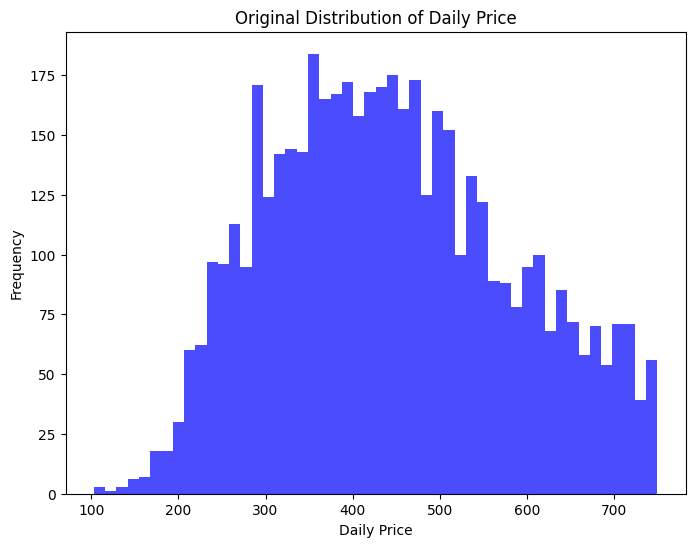

In [7]:
import matplotlib.pyplot as plt
# Visualizing the distribution of the original daily_price
plt.figure(figsize=(8, 6))
plt.hist(df_ml['daily_price'], bins=50, color='blue', alpha=0.7)
plt.title('Original Distribution of Daily Price')
plt.xlabel('Daily Price')
plt.ylabel('Frequency')
plt.show()

### 2. Feature Engineering

#### Preprocessing Function
Have a preprocessing pipeline created to apply the necessary transformations to the dataframe:
  + One-Hot Encoding: For the categorical feature `city`;
  + Box-Cox Transformation: For numerical feature `city_center_dist_km`;
  + Logarithmic (Log_e) Transformation: For numerical feature `metro_dist_km`; 
  + Passthrough: For features that don’t require transformation, like `bedrooms`.


In [9]:
def preprocess_data():
    # Define the numerical and categorical features
    categorical_features = ['city']
    numerical_features_boxcox = ['city_center_dist_km']  
    numerical_features_log = ['metro_dist_km']      
        
    # One-hot encoder for city
    categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # Define transformers for numerical and categorical features
    numerical_transformer_boxcox = PowerTransformer(method='box-cox')      
    numerical_transformer_log = FunctionTransformer(np.log1p, validate=True)

    # # Interaction terms
    # interaction_features = ['city_center_dist_km', 'bedrooms']
    # interaction_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

    # One-hot encoder for city
    # categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')  
    
    # Combine the transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            # ('num_boxcox', numerical_transformer_boxcox, numerical_features_boxcox),            
            ('cat', categorical_transformer, categorical_features),
            ('num_boxcox', numerical_transformer_boxcox, numerical_features_boxcox),
            ('num_log', numerical_transformer_log, numerical_features_log),            
        ],
        remainder='passthrough'  
    )
    
    return preprocessor


# Defining and Training  ML

In [10]:
def check_best_pipeline(X_train, X_test, y_train, y_test):
    """
    Function to check multiple models with preprocessing and hyperparameter tuning.
    Returns the best model and results for each.
    """
    # Define the models to test
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }

    # Define the hyperparameter grids for each model
    param_grids = {
        'Linear Regression': {},  # No hyperparameters for linear regression
        'Ridge Regression': {'model__alpha': [0.1, 1.0, 10]},
        'Lasso Regression': {'model__alpha': [0.01, 0.1, 1.0]},
        'Gradient Boosting': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    }
    
    results = {}
    best_pipelines = {}  # To store the best pipeline for each model

    # Loop through each model
    for model_name, model in models.items():
        print(f"Running {model_name} with hyperparameter tuning...")
        
        # Create a pipeline for each model with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocess_data()),  # Preprocessing step
            ('model', model)  # Model step
        ])
        
        # Use GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
        
        # Fit the model with the best hyperparameters
        grid_search.fit(X_train, y_train)
        
        # Get the best model pipeline
        best_pipeline = grid_search.best_estimator_
        best_pipelines[model_name] = best_pipeline
        
        # Make predictions on the test set
        y_pred_log = best_pipeline.predict(X_test)
        y_pred = np.expm1(y_pred_log)  # Inverse log transformation
        
        # Evaluate the model
        mae = mean_absolute_error(np.expm1(y_test), y_pred)
        mse = mean_squared_error(np.expm1(y_test), y_pred)
        r2 = r2_score(np.expm1(y_test), y_pred)
        
        # Store the results, including the best hyperparameters
        results[model_name] = {
            'Best Hyperparameters': grid_search.best_params_,
            'Mean Absolute Error': mae,
            'Mean Squared Error': mse,
            'R² Score': r2
        }

    return results, best_pipelines  # Return both the results and the best pipelines


### Preparing Data 

Have the features (X) and the target variable (y) defined, and the log transformation applied to the target (daily_price) to help normalize it.

In [11]:
X = df_ml[['city', 'bedrooms', 'city_center_dist_km', 'metro_dist_km']]
y = np.log1p(df_ml['daily_price'])

Visualising the Log-Transformed `daily_price`

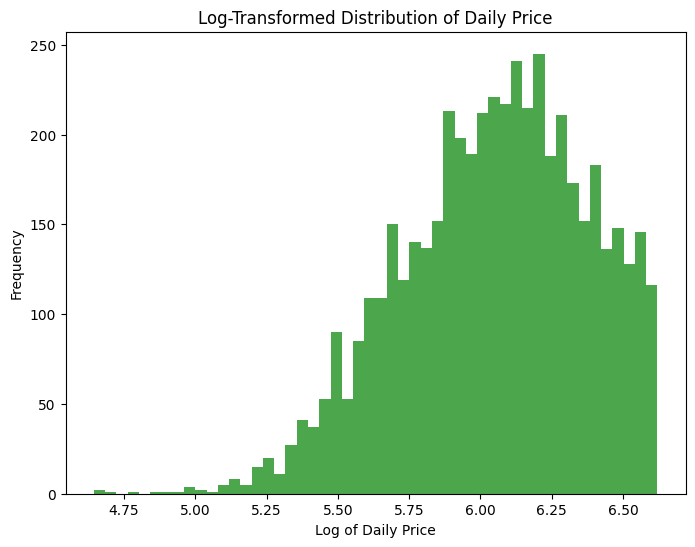

In [12]:
df_ml['log_daily_price'] = np.log1p(df_ml['daily_price'])

# Visualizing the distribution of log-transformed daily_price
plt.figure(figsize=(8, 6))
plt.hist(df_ml['log_daily_price'], bins=50, color='green', alpha=0.7)
plt.title('Log-Transformed Distribution of Daily Price')
plt.xlabel('Log of Daily Price')
plt.ylabel('Frequency')
plt.show()

Have the dataframe split into training and testing sets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Run the Model and Check the Best Pipeline

Have the `check_best_pipeline()` function run to check which model performs the best.

In [14]:
# Run the function to try multiple models with hyperparameter tuning
results, best_pipelines = check_best_pipeline(X_train, X_test, y_train, y_test)

# Display the results for each model
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    print(f"Best Hyperparameters: {metrics['Best Hyperparameters']}")
    print(f"Mean Absolute Error: {metrics['Mean Absolute Error']}")
    print(f"Mean Squared Error: {metrics['Mean Squared Error']}")
    print(f"R² Score: {metrics['R² Score']}")
    print('-' * 50)

Running Linear Regression with hyperparameter tuning...


Running Ridge Regression with hyperparameter tuning...
Running Lasso Regression with hyperparameter tuning...
Running Gradient Boosting with hyperparameter tuning...
Results for Linear Regression:
Best Hyperparameters: {}
Mean Absolute Error: 85.7472128569867
Mean Squared Error: 11055.597679473422
R² Score: 0.44261618714081175
--------------------------------------------------
Results for Ridge Regression:
Best Hyperparameters: {'model__alpha': 0.1}
Mean Absolute Error: 85.74645760450886
Mean Squared Error: 11054.963124107679
R² Score: 0.4426481791596498
--------------------------------------------------
Results for Lasso Regression:
Best Hyperparameters: {'model__alpha': 0.01}
Mean Absolute Error: 89.20716506657892
Mean Squared Error: 11987.798181346248
R² Score: 0.39561796188449316
--------------------------------------------------
Results for Gradient Boosting:
Best Hyperparameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300}
Mean Absolute Error:

### Analysing Feature Importance

Accessing the best Gradient Boosting pipeline...
Preprocessor structure: ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['city']),
                                ('num_boxcox',
                                 PowerTransformer(method='box-cox'),
                                 ['city_center_dist_km']),
                                ('num_log',
                                 FunctionTransformer(func=<ufunc 'log1p'>,
                                                     validate=True),
                                 ['metro_dist_km'])])
Number of features (from feature_names): 6
Number of importances (from model): 6


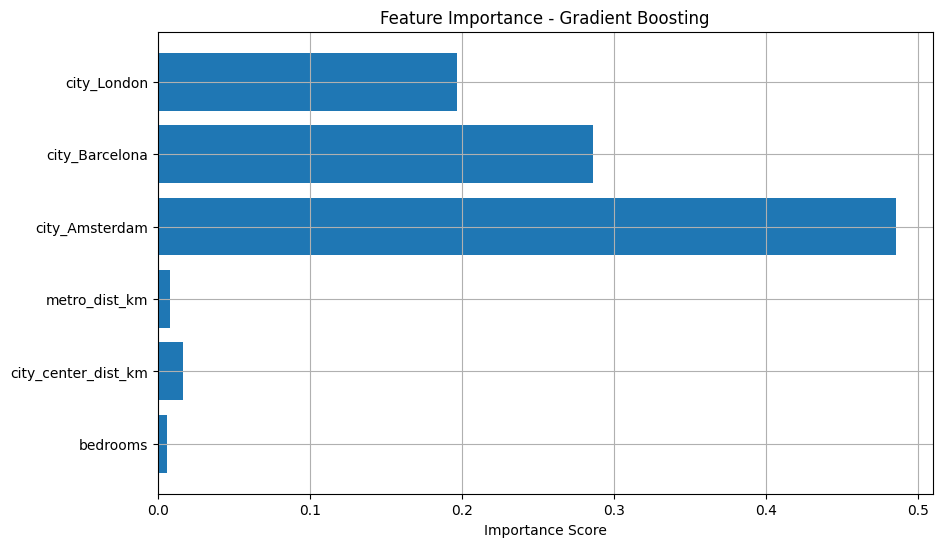

In [15]:
best_gb_pipeline = best_pipelines.get('Gradient Boosting')

if best_gb_pipeline:
    print("Accessing the best Gradient Boosting pipeline...")

    # Access the fitted Gradient Boosting model inside the pipeline
    best_gb_model = best_gb_pipeline.named_steps['model']
    
    # Check feature importance
    importances = best_gb_model.feature_importances_
    
    # Get the preprocessor
    preprocessor = best_gb_pipeline.named_steps['preprocessor']
    
    # Print structure to debug the transformers
    print("Preprocessor structure:", preprocessor)

    try:
        # Access the OneHotEncoder from the 'cat' transformer
        one_hot_encoder = preprocessor.named_transformers_['cat']  # This is the OneHotEncoder for 'city'
        
        # Try to use get_feature_names_out(), fallback to get_feature_names()
        try:
            categorical_columns = one_hot_encoder.get_feature_names_out(['city'])
        except AttributeError:
            categorical_columns = one_hot_encoder.get_feature_names(['city'])  # Fallback for older versions of scikit-learn

        # Combine the numerical feature names manually
        numerical_features = ['bedrooms', 'city_center_dist_km', 'metro_dist_km']
        feature_names = numerical_features + list(categorical_columns)

        # Debugging: Check the lengths of feature_names and importances
        print("Number of features (from feature_names):", len(feature_names))
        print("Number of importances (from model):", len(importances))

        # Ensure the lengths match
        if len(feature_names) == len(importances):
            # Plot the feature importance
            plt.figure(figsize=(10, 6))
            plt.barh(feature_names, importances)
            plt.title('Feature Importance - Gradient Boosting')
            plt.xlabel('Importance Score')
            plt.grid(True)
            plt.show()
        else:
            print("Error: The number of feature names and importances do not match.")

    except AttributeError as e:
        print(f"Error: {e}")
        print("Ensure you're accessing the correct OneHotEncoder in the pipeline.")


Number of features (from feature_names): 6
Number of importances (from model): 6


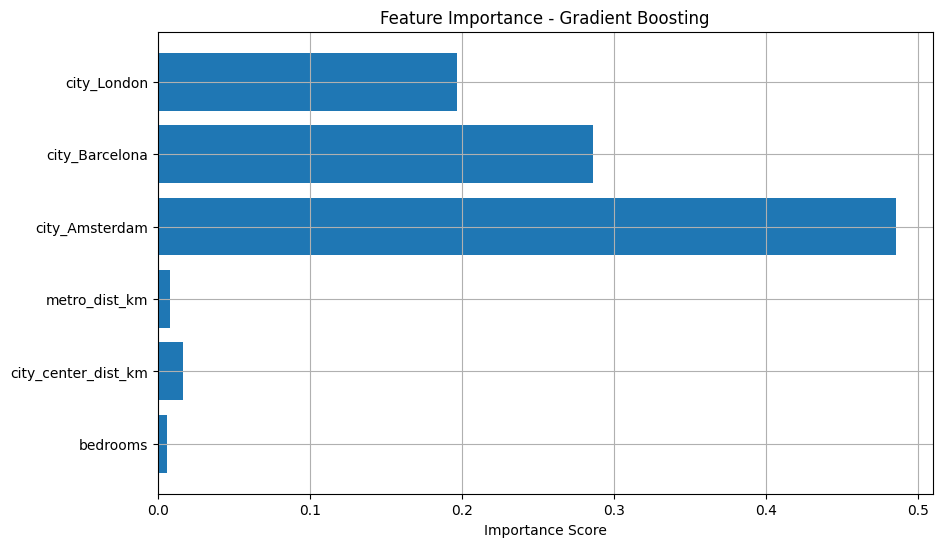

Mean Absolute Error (Final Model): 62.27919536292399
Mean Squared Error (Final Model): 8525.930990080235
R² Score (Final Model): 0.5701529613140207


In [16]:
# Finalize the Gradient Boosting Model (best model from hyperparameter tuning)
best_gb_pipeline = best_pipelines.get('Gradient Boosting')

if best_gb_pipeline:
    # Access the fitted Gradient Boosting model inside the pipeline
    best_gb_model = best_gb_pipeline.named_steps['model']

    # Feature Importance Analysis
    importances = best_gb_model.feature_importances_

    # Get the preprocessor
    preprocessor = best_gb_pipeline.named_steps['preprocessor']

    try:
        # Access the OneHotEncoder from the 'cat' transformer
        one_hot_encoder = preprocessor.named_transformers_['cat']  # This is the OneHotEncoder for 'city'
        
        # Try to use get_feature_names_out(), fallback to get_feature_names()
        try:
            categorical_columns = one_hot_encoder.get_feature_names_out(['city'])
        except AttributeError:
            categorical_columns = one_hot_encoder.get_feature_names(['city'])  # Fallback for older versions of scikit-learn

        # Combine the numerical feature names manually
        numerical_features = ['bedrooms', 'city_center_dist_km', 'metro_dist_km']
        feature_names = numerical_features + list(categorical_columns)

        # Debugging: Check the lengths of feature_names and importances
        print("Number of features (from feature_names):", len(feature_names))
        print("Number of importances (from model):", len(importances))

        # Ensure the lengths match
        if len(feature_names) == len(importances):
            # Plot the feature importance
            plt.figure(figsize=(10, 6))
            plt.barh(feature_names, importances)
            plt.title('Feature Importance - Gradient Boosting')
            plt.xlabel('Importance Score')
            plt.grid(True)
            plt.show()
        else:
            print("Error: The number of feature names and importances do not match.")

        # Make final predictions using the best Gradient Boosting pipeline
        y_pred_log = best_gb_pipeline.predict(X_test)
        y_pred = np.expm1(y_pred_log)  # Inverse log transform the predictions

        # Evaluate the final model (no need to inverse log transform y_test again)
        mae = mean_absolute_error(np.expm1(y_test), y_pred)
        mse = mean_squared_error(np.expm1(y_test), y_pred)
        r2 = r2_score(np.expm1(y_test), y_pred)

        print(f"Mean Absolute Error (Final Model): {mae}")
        print(f"Mean Squared Error (Final Model): {mse}")
        print(f"R² Score (Final Model): {r2}")

    except AttributeError as e:
        print(f"Error: {e}")
        print("Ensure you're accessing the correct OneHotEncoder in the pipeline.")


# Pushing File to Repo

In [17]:
import joblib
import os
import matplotlib.pyplot as plt

# Specify version and file path
version = 'v1'
file_path = f'outputs/ml_pipeline/airbnb_price_prediction/{version}'

# Create the directory if it doesn't exist
try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)


In [18]:
# Save the final Gradient Boosting pipeline
joblib.dump(value=best_gb_pipeline, filename=f"{file_path}/price_prediction_pipeline.pkl")

['outputs/ml_pipeline/airbnb_price_prediction/v1/price_prediction_pipeline.pkl']

In [19]:
df_ml.to_csv(f"{file_path}/TrainSet.csv", index=False)

Feature Names: ['bedrooms', 'city_center_dist_km', 'metro_dist_km', 'city_Amsterdam', 'city_Barcelona', 'city_London']
Importances: [0.00597877 0.01684373 0.00830279 0.48549538 0.28622327 0.19715606]


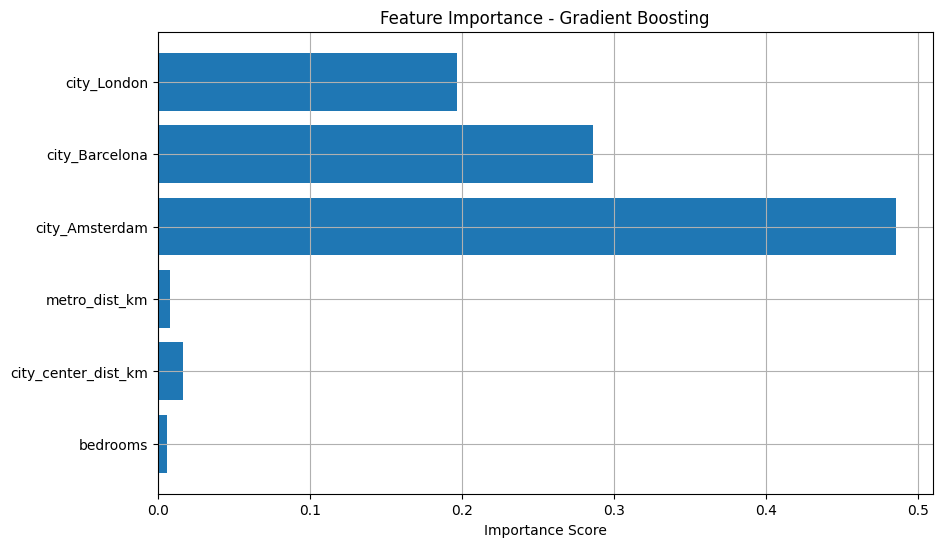

In [20]:
# Save the feature importance plot
importances = best_gb_model.feature_importances_

# Get the preprocessor from the pipeline
preprocessor = best_gb_pipeline.named_steps['preprocessor']

# Try to retrieve feature names for the categorical columns (city) from OneHotEncoder
try:
    one_hot_encoder = preprocessor.named_transformers_['cat']  # Access the OneHotEncoder for 'city'
    
    # Try to use get_feature_names_out(), fallback to get_feature_names()
    try:
        city_feature_names = one_hot_encoder.get_feature_names_out(['city'])
    except AttributeError:
        city_feature_names = one_hot_encoder.get_feature_names(['city'])  # For older versions of scikit-learn

    # Combine the feature names for numerical and categorical columns
    feature_names = ['bedrooms', 'city_center_dist_km', 'metro_dist_km'] + list(city_feature_names)

    # Debugging: Print feature names and importances lengths
    print("Feature Names:", feature_names)
    print("Importances:", importances)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances)
    plt.title('Feature Importance - Gradient Boosting')
    plt.xlabel('Importance Score')
    plt.grid(True)
    plt.show()

except AttributeError as e:
    print(f"Error: {e}")
    print("Ensure you're accessing the correct OneHotEncoder in the pipeline.")


In [21]:
# Save the performance metrics (MAE, MSE, R²)
mae = mean_absolute_error(np.expm1(y_test), y_pred)
mse = mean_squared_error(np.expm1(y_test), y_pred)
r2 = r2_score(np.expm1(y_test), y_pred)

In [22]:
# Save the results in a CSV
with open(f"{file_path}/model_performance.csv", 'w') as f:
    f.write('Metric,Value\n')
    f.write(f'Mean Absolute Error,{mae}\n')
    f.write(f'Mean Squared Error,{mse}\n')
    f.write(f'R² Score,{r2}\n')

print("Files saved successfully.")

Files saved successfully.
